In [1]:
import dlib
import cv2 
import matplotlib.pyplot as plt 
import numpy as np 
import os 
from imutils import face_utils

In [2]:
def eda_video(path_video):
    '''
        Hàm để lấy các tính chất của một video như: FPS, width, height, số lượng frame của video
        Đầu vào: Đường dẫn video
        Đầu ra: các tính chất của video
    '''
    #Đọc video
    vidcap = cv2.VideoCapture(path_video)
    #Lấy số lượng image trong video
    frame_img = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    #Tính FPS của video
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    #Lấy kích thước của video
    width = np.int32(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = np.int32(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    #Lấy toàn bộ ảnh trong video
    imgs = []
    while True:
        ret, frame = vidcap.read()
        if ret:
            imgs.append(frame)
        else:
            break

    vidcap.release()
    #Kiểm tra số lượng image trong video
    if len(imgs) != frame_img:
        frame_img = len(imgs)
        
    return imgs, frame_img, fps, width, height
# print(imgs, frame_img, fps, width, height)

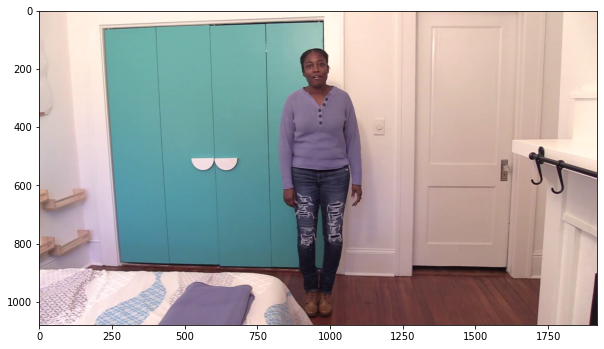

In [3]:
#Test hàm eda_video()
path_video = r'D:\[Project]_Deep_Fake\Deep_Fake\datasets\train_sample_videos\dakiztgtnw.mp4'
imgs, frame_img, fps, width, height = eda_video(path_video)
#Hiển thị thử 1 ảnh trong list imgs
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(imgs[0], cv2.COLOR_RGB2BGR))
plt.show()

In [19]:
def load_dlib(path):
    ''' 
        Load model dlib to predict face and lamrk in face
        Input: path contain model dlib
        Output: model dlib
    '''
    front_face_detector = dlib.get_frontal_face_detector()
    lmark_predictor = dlib.shape_predictor(path)

    return front_face_detector, lmark_predictor

def shape_to_np(shape, dtype="int"):
    ''' 
        Lấy tọa độ các điểm trên khuôn mặt lưu dưới dạng tuple và lưu vào một np
        Đầu vào: list tọa độ các điểm predict
        Đầu ra: array các tuple của các điểm predict, mỗi tuple có 2 elements đại diện cho x, y
    '''
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)

    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coords
    
def umeyama(src, dst, estimate_scale):
    ''' 
        umeyama function from scikit-image/skimage/transform/_geometric.py

        Estimate N-D similarity transformation with or without scaling.
        Parameters
        ----------
        src : (M, N) array
            Source coordinates.
        dst : (M, N) array
            Destination coordinates.
        estimate_scale : bool
            Whether to estimate scaling factor.
        Returns
        -------
        T : (N + 1, N + 1)
            The homogeneous similarity transformation matrix. The matrix contains
            NaN values only if the problem is not well-conditioned.
        
        References
        ----------
        .. [1] "Least-squares estimation of transformation parameters between two
                point patterns", Shinji Umeyama, PAMI 1991, DOI: 10.1109/34.88573
        '''

    num = src.shape[0]
    dim = src.shape[1]

    #Compute mean of src and dst 
    src_mean = src.mean(axis=0)
    dst_mean = dst.mean(axis=0)

    #Subtract mean from src and dst
    src_demean = src - src_mean
    dst_demean = dst - dst_mean
    # Eq. (38).
    A = np.dot(dst_demean.T, src_demean) / num

    # Eq. (39).
    d = np.ones((dim,), dtype=np.double)
    if np.linalg.det(A) < 0:
        d[dim - 1] = -1

    T = np.eye(dim + 1, dtype=np.double)

    U, S, V = np.linalg.svd(A)

    # Eq. (40) and (43).
    rank = np.linalg.matrix_rank(A)
    if rank == 0:
        return np.nan * T
    elif rank == dim - 1:
        if np.linalg.det(U) * np.linalg.det(V) > 0:
            T[:dim, :dim] = np.dot(U, V)
        else:
            s = d[dim - 1]
            d[dim - 1] = -1
            T[:dim, :dim] = np.dot(U, np.dot(np.diag(d), V))
            d[dim - 1] = s
    else:
        T[:dim, :dim] = np.dot(U, np.dot(np.diag(d), V.T))

    if estimate_scale:
        # Eq. (41) and (42).
        scale = 1.0 / src_demean.var(axis=0).sum() * np.dot(S, d)
    else:
        scale = 1.0

    T[:dim, dim] = dst_mean - scale * np.dot(T[:dim, :dim], src_mean.T)
    T[:dim, :dim] *= scale

    return T

def align(img, face_detector, lmark_predictor):
    ''' 
        Lấy tất cả các khuôn mặt trong video và matrix translate điều chỉnh tọa độ mắt ngang nhau 
        và lấy ảnh mắt trái và phải 
    '''
    img = np.uint8(img)
    faces = face_detector(img)
    face_list = []
    # print("Face:", faces)
    if faces is not None or len(faces) > 0:
        for pred in faces:
            print(type(pred))
            points = shape_to_np(lmark_predictor(img, pred))
            # print("Points:", len(points))
            # print(landmarks_2D.shape, points[17:].shape)
            trans_matrix = umeyama(points[17:], landmarks_2D, True)[0:2]
            # print("Trans_matrix:", trans_matrix)
            face_list.append([trans_matrix, points])
            # print("Face_list:", face_list)
    
    return face_list, faces

In [20]:
#Tọa độ các điểm như mắt, mũi, miệng,... trên khuôn mặt do người nghiên cứu tìm ra 
mean_face_x = np.array([
    0.000213256, 0.0752622, 0.18113, 0.29077, 0.393397, 0.586856, 0.689483, 0.799124,
    0.904991, 0.98004, 0.490127, 0.490127, 0.490127, 0.490127, 0.36688, 0.426036,
    0.490127, 0.554217, 0.613373, 0.121737, 0.187122, 0.265825, 0.334606, 0.260918,
    0.182743, 0.645647, 0.714428, 0.793132, 0.858516, 0.79751, 0.719335, 0.254149,
    0.340985, 0.428858, 0.490127, 0.551395, 0.639268, 0.726104, 0.642159, 0.556721,
    0.490127, 0.423532, 0.338094, 0.290379, 0.428096, 0.490127, 0.552157, 0.689874,
    0.553364, 0.490127, 0.42689])

mean_face_y = np.array([
    0.106454, 0.038915, 0.0187482, 0.0344891, 0.0773906, 0.0773906, 0.0344891,
    0.0187482, 0.038915, 0.106454, 0.203352, 0.307009, 0.409805, 0.515625, 0.587326,
    0.609345, 0.628106, 0.609345, 0.587326, 0.216423, 0.178758, 0.179852, 0.231733,
    0.245099, 0.244077, 0.231733, 0.179852, 0.178758, 0.216423, 0.244077, 0.245099,
    0.780233, 0.745405, 0.727388, 0.742578, 0.727388, 0.745405, 0.780233, 0.864805,
    0.902192, 0.909281, 0.902192, 0.864805, 0.784792, 0.778746, 0.785343, 0.778746,
    0.784792, 0.824182, 0.831803, 0.824182])

#Tọa độ các điểm trên khuôn mặt
landmarks_2D = np.stack([mean_face_x, mean_face_y], axis=1)

SCALE_FACTOR = 1
FEATHER_AMOUNT = 11

FACE_POINTS = list(range(17, 68))
MOUTH_POINTS = list(range(48, 61))
RIGHT_BROW_POINTS = list(range(17, 22))
LEFT_BROW_POINTS = list(range(22, 27))
RIGHT_EYE_POINTS = list(range(36, 42))
LEFT_EYE_POINTS = list(range(42, 48))
NOSE_POINTS = list(range(27, 35))
JAW_POINTS = list(range(0, 17))

# Points used to line up the images.
ALIGN_POINTS = (LEFT_BROW_POINTS + RIGHT_EYE_POINTS + LEFT_EYE_POINTS +
                RIGHT_BROW_POINTS + NOSE_POINTS + MOUTH_POINTS)

# Amount of blur to use during colour correction, as a fraction of the
# pupillary distance.
COLOUR_CORRECT_BLUR_FRAC = 0.6

#Load model dlib 
path = 'dlib_model/shape_predictor_68_face_landmarks.dat'
front_face_detector, lmark_predictor = load_dlib(path)
face_list, faces = align(imgs[20], front_face_detector, lmark_predictor)


<class '_dlib_pybind11.rectangle'>


In [ ]:
print(face_list)

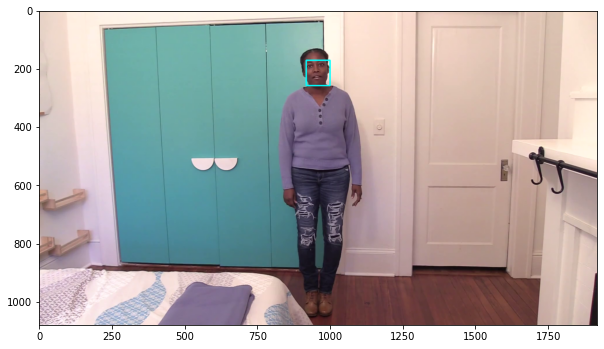

In [22]:
#Visualize face detected in image 
x_max, y_max = np.max(face_list[0][1], axis=0)
x_min, y_min = np.min(face_list[0][1], axis=0)

image_rec = cv2.rectangle(imgs[0].copy(), (x_min, y_min), (x_max, y_max), (255, 255, 0), 4)
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(image_rec, cv2.COLOR_RGB2BGR))
plt.show()

In [5]:
def get_2d_aligned_face(image, mat, size=256, padding=[0, 0]):
    ''' 
        Lấy tất cả các khuôn mặt trong image bằng cách trượt và scale qua image
        giống như kiểu xoay ảnh(rotation),... bằng matrix transate,..
        Đầu vào: 
         --Image: ảnh gốc
         --Mat: matrix trans/scale được tìm bằng thuật toán least square estimattion bằng hàm umeyama
         ở trên 
         -- size: kích thước khuôn mặt mình muốn (mình tự định nghĩa)
        Đầu ra: Khuôn mặt được scale và 2 con mắt có tọa độ y bằng nhau(ngang nhau) nhờ matrix trans tìm được ở umeyama.
    '''
    mat = mat * size
    mat[0, 2] += padding[0]
    mat[1, 2] += padding[1]
    return cv2.warpAffine(image, mat, (size + 2 * padding[0], size + 2 * padding[1]))

# #Test hàm get_2d_aligned_face()
# image = get_2d_aligned_face(imgs[100], face_list[0][0])
# print(image.shape)
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
# plt.show()

def get_aligned_face_and_landmarks(im, face_list, aligned_face_size = 256, padding=(0, 0)):
    """
    get all aligned faces and landmarks of all images
    :param imgs: origin images
    :param fa: face_alignment package
    ==================
    :return: trả về ảnh khuôn mặt yêu cầu và ma trận để tính toán thu được ảnh mắt 
    """
    aligned_cur_shapes = []
    aligned_cur_im = []
    for mat, points in face_list:
        # Get transform matrix (thu được hình ảnh khuôn mặt)
        aligned_face = get_2d_aligned_face(im, mat, aligned_face_size, padding)
        # Mapping landmarks to aligned face
        pred_ = np.concatenate([points, np.ones((points.shape[0], 1))], axis=-1)
        pred_ = np.transpose(pred_)
        mat = mat * aligned_face_size
        mat[0, 2] += padding[0]
        mat[1, 2] += padding[1]
        aligned_pred = np.dot(mat, pred_)
        aligned_pred = np.transpose(aligned_pred[:2, :])
        aligned_cur_shapes.append(aligned_pred)
        aligned_cur_im.append(aligned_face)

    return aligned_cur_im, aligned_cur_shapes 

def crop_eye(img, points):
    '''
        Tính toán lấy ảnh mắt trái và phải của face
        Input: image chứa face, tọa độ các điểm đặc biệt trên khuôn mặt
        Output: ảnh mắt trái và phải của khuôn mặt
    '''
    eyes_list = []

    left_eye = points[36:42, :]
    right_eye = points[42:48, :]

    eyes = [left_eye, right_eye]
    for j in range(len(eyes)):
        lp = np.min(eyes[j][:, 0])
        rp = np.max(eyes[j][:, 0])
        tp = np.min(eyes[j][:, -1])
        bp = np.max(eyes[j][:, -1])

        w = rp - lp
        h = bp - tp

        lp_ = int(np.maximum(0, lp - 0.25 * w))
        rp_ = int(np.minimum(img.shape[1], rp + 0.25 * w))
        tp_ = int(np.maximum(0, tp - 1.75 * h))
        bp_ = int(np.minimum(img.shape[0], bp + 1.75 * h))

        eyes_list.append(img[tp_:bp_, lp_:rp_, :])

    return eyes_list

# Ham tinh khoang cach giua 2 diem
def e_dist(pA, pB):
	return np.linalg.norm(pA - pB)

def eye_ratio(eye):
	# Tinh toan khoang cach theo chieu doc giua mi tren va mi duoi
	d_V1 = e_dist(eye[1], eye[5])
	d_V2 = e_dist(eye[2], eye[4])

	# Tinh toan khoang cach theo chieu ngang giua 2 duoi mat
	d_H = e_dist(eye[0], eye[3])

	# Tinh ty le giua chieu doc va chieu ngang
	eye_ratio_val = (d_V1 + d_V2) / (2.0 * d_H)

	return eye_ratio_val

# # Lay danh sach cac cum diem landmark cho 2 mat
# (left_eye_start, left_eye_end) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
# (right_eye_start, right_eye_end) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

# face_gray = cv2.cvtColor(imgs[0], cv2.COLOR_RGB2GRAY)
# print(faces[0])
# # Nhan dien cac diem landmark
# # Tao mot hinh chu nhat quanh khuon mat
# landmark = lmark_predictor(face_gray, faces[0])
# landmark = face_utils.shape_to_np(landmark)
# print(len(landmark))
# # Tinh toan ty le mat phai va trai va trung binh cong 2 ratio
# leftEye = landmark[left_eye_start:left_eye_end]
# rightEye = landmark[right_eye_start:right_eye_end]
# # print(leftEye , rightEye)
# #Tính tỷ lệ mắt trái, phải để xác định mắt mở hay đóng để label 
# left_eye_ratio = eye_ratio(leftEye)
# right_eye_ratio = eye_ratio(rightEye)
# print(left_eye_ratio, right_eye_ratio)

# # Ve duong bao quanh mat
# left_eye_bound = cv2.convexHull(leftEye)
# right_eye_bound = cv2.convexHull(rightEye)
# cv2.drawContours(imgs[0], [left_eye_bound], -1, (0, 255, 0), 1)
# cv2.drawContours(imgs[0], [right_eye_bound], -1, (0, 255, 0), 1)


# factor = float(300) / height
# aligned_cur_im, aligned_cur_shapes = get_aligned_face_and_landmarks(imgs[0], face_list)
# # crop eyes
# leye, reye = crop_eye(aligned_cur_im[0], aligned_cur_shapes[0])
# im_resized = cv2.resize(imgs[0], None, None, fx=factor, fy=factor)

# print(leye.shape, reye.shape)
# _, image = plt.subplots(1, 4, figsize=(10,10))
# image[0].imshow(cv2.cvtColor(aligned_cur_im[0], cv2.COLOR_RGB2BGR))
# image[1].imshow(cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
# image[2].imshow(cv2.cvtColor(leye, cv2.COLOR_RGB2BGR))
# image[3].imshow(cv2.cvtColor(reye, cv2.COLOR_RGB2BGR))
# plt.show()

In [6]:
import pathlib
from tqdm import tqdm 
from imutils import face_utils
#file chứa path ảnh và label ảnh 
path_data_npy = 'data_train.npy'
list_path_eye = []
label_eye = []

#Lấy tất cả các video trong datasets
path_folder = pathlib.Path('datasets/train_sample_videos')
path_videos = sorted(list(path_folder.glob("*mp4")))

#Load model dlib 
root_model = 'dlib_model/shape_predictor_68_face_landmarks.dat'
front_face_detector, lmark_predictor = load_dlib(root_model)

#Create folder contain image eyes 
data_eyes = 'sample_data_eyes/'
if not os.path.exists(data_eyes):
    os.mkdir(data_eyes)

number_image = 0

In [ ]:
# Lay danh sach cac cum diem landmark cho 2 mat
(left_eye_start, left_eye_end) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(right_eye_start, right_eye_end) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

#Xử lí và label các ảnh mắt đóng và mở 
for path in path_videos[:50]:
    print(path)
    imgs, frame_img, fps, width, height = eda_video(f'{path}')
    #Size image 
    factor = float(300) / height
    #Lấy ảnh mắt trái, phải và ảnh resize  
    left_eyes = []
    right_eyes = []
    align_imgs = []
    for i, img in enumerate(tqdm(imgs)):
        #Chuyển ảnh sang gray 
        face_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        #Lấy tọa độ và crop ảnh khuôn mặt trong ảnh 
        face_ache, faces = align(img, front_face_detector, lmark_predictor)
        
        # Nhan dien cac diem landmark
        # Tao mot hinh chu nhat quanh khuon mat
        if len(face_ache) > 0:
            landmark = lmark_predictor(face_gray, faces[0])
            landmark = face_utils.shape_to_np(landmark)

            #Lấy tọa độ ảnh mắt trái và phải (khung chứa ảnh trái và phải)
            leftEye = landmark[left_eye_start:left_eye_end]
            rightEye = landmark[right_eye_start:right_eye_end]

            #Tính tỷ lệ mắt trái, phải để xác định mắt mở hay đóng để label 
            left_eye_ratio = eye_ratio(leftEye)
            right_eye_ratio = eye_ratio(rightEye)
            # print(left_eye_ratio, right_eye_ratio)
        
            if len(face_ache) == 0:
                left_eyes.append(None)
                right_eyes.append(None)
                continue
            if len (face_ache) > 1:
                continue

            aligned_cur_im, aligned_cur_shapes = get_aligned_face_and_landmarks(img, face_ache)
            # crop eyes
            leye, reye = crop_eye(aligned_cur_im[0], aligned_cur_shapes[0])
            im_resized = cv2.resize(img, None, None, fx=factor, fy=factor)

            cv2.imwrite(data_eyes + '{:09n}'.format(number_image) + '.png', leye)
            list_path_eye.append(data_eyes + '{:09n}'.format(number_image) + '.png')
            cv2.imwrite(data_eyes + '{:09n}'.format(number_image + 1) + '.png', reye)
            list_path_eye.append(data_eyes + '{:09n}'.format(number_image + 1) + '.png')
            label_eye.append([1 if left_eye_ratio > 0.25 else 0])
            label_eye.append([1 if right_eye_ratio > 0.25 else 0])

            #Kiểm tra quá trình label
            if len(label_eye) % 200 == 0:
                print(list_path_eye[len(label_eye) - i], label_eye[len(label_eye) - i])

            number_image += 2
            left_eyes.append(leye)
            right_eyes.append(reye)
            align_imgs.append(im_resized)
        else:
            continue
        
#Save data with numpy file npy
data = [i for i in zip(list_path_eye, label_eye)]
np.save(path_data_npy, data)

In [4]:
import numpy as np 

data = np.load('data_train.npy', allow_pickle=True)

In [ ]:
import cv2 

path = data[100][0].split('/')[0]
number = data[100][0].split('/')[1].split('.')[0]
path_image = path + '/' + '{:09n}'.format(int(number)) + '.png'
print(path_image)

label = data[100][1]
print(int(label[0]) == 1)

image = cv2.imread(path_image)
# print(image)

In [33]:
from collections import Counter

Counter(int(label[0]) == 1 for label in data[:, 1])

Counter({True: 18620, False: 7850})

In [58]:
labels = [int(i[0]) for i in data[:, 1]]
index = np.where(np.array(labels) == 0)
print(index[0][:10])

[ 7  8  9 11 58 59 60 61 62 63]


In [77]:
list_path = []
list_labels = []

for i in range(len(data)):
    path = data[i][0].split('/')[0]
    number = data[i][0].split('/')[1].split('.')[0]
    path_image = path + '/' + '{:09n}'.format(int(number)) + '.png'
    # print(path_image)
    if int(data[i][1][0]) == 1:
        list_path.append(path_image)
        list_labels.append(data[i][1][0])
    if len(list_labels) == 10000:
        break


In [80]:
for i in index[0]:
    path = data[i][0].split('/')[0]
    number = data[i][0].split('/')[1].split('.')[0]
    path_image = path + '/' + '{:09n}'.format(int(number)) + '.png'
    list_path.append(path_image)
    list_labels.append(data[i][1][0])

In [87]:
data_training_20000 = [i for i in zip(list_path, list_labels)]
random_idx = np.random.permutation(len(data_training_20000))
data_20000 = [data_training_20000[i] for i in random_idx]
data_20000[:20]

[('sample_data_eyes/000016442.png', 0),
 ('sample_data_eyes/000006436.png', 1),
 ('sample_data_eyes/000021902.png', 0),
 ('sample_data_eyes/000009648.png', 0),
 ('sample_data_eyes/000002492.png', 1),
 ('sample_data_eyes/000013037.png', 1),
 ('sample_data_eyes/000022722.png', 0),
 ('sample_data_eyes/000002998.png', 1),
 ('sample_data_eyes/000002017.png', 1),
 ('sample_data_eyes/000000433.png', 1),
 ('sample_data_eyes/000000439.png', 1),
 ('sample_data_eyes/000007723.png', 0),
 ('sample_data_eyes/000004899.png', 1),
 ('sample_data_eyes/000020807.png', 0),
 ('sample_data_eyes/000008555.png', 0),
 ('sample_data_eyes/000005088.png', 1),
 ('sample_data_eyes/000012128.png', 1),
 ('sample_data_eyes/000005671.png', 0),
 ('sample_data_eyes/000011275.png', 1),
 ('sample_data_eyes/000012600.png', 1)]

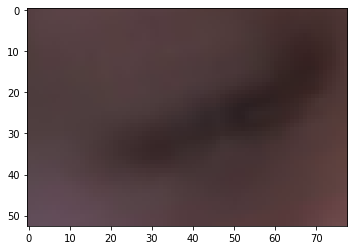

In [90]:
import matplotlib.pylab as plt 

image = cv2.imread(data_20000[0][0])

plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
plt.show()

In [93]:
np.save('data_20000.npy', np.array(data_20000))

In [94]:
data_2 = np.load('data_20000.npy', allow_pickle=True)
data_2

array([['sample_data_eyes/000016442.png', '0'],
       ['sample_data_eyes/000006436.png', '1'],
       ['sample_data_eyes/000021902.png', '0'],
       ...,
       ['sample_data_eyes/000017828.png', '0'],
       ['sample_data_eyes/000010326.png', '1'],
       ['sample_data_eyes/000018389.png', '0']], dtype='<U30')

In [1]:
import numpy as np 
import cv2 
import os 
import matplotlib.pyplot as plt 
import tensorflow as tf

#Chuẩn bị data để training (data agument)
anno_path = 'data_20000.npy'
data_dir = 'datasets/'
batch_size = 16
is_agument = False
is_shuffle = False

#Load data train
data_annos = np.load(anno_path, allow_pickle=True)
# print(data_annos)

#Get data number
data_num = len(data_annos)
# print(data_num)
batch_num = np.int32(np.ceil(data_num/batch_size))
# print(batch_num)

def get_batch(batch_index, size=None):
    if batch_index >= batch_num:
        raise ValueError("Batch idx must be in range [0, {}].".format(batch_num - 1))
    
    #Get start and end image index (counting from 0)
    #Chia khoảng và lấy 16 image làm trong 1 lần train 
    start_idx = batch_index * batch_size
    idx_range = []
    for i in range(batch_size):
        idx_range.append((start_idx + i) % data_num)
    
    print('Batch index: {}, counting from 0'.format(batch_index))

    img_tensor = []
    label_list = []
    img_name_list = []
    for i in idx_range:
        #path_name and label
        img_name, label = data_annos[i]
        img = cv2.imread(data_dir + img_name)

        #image agument 
        #Xử lí sau ........

        if size is not None:
            #Padding and resize to out 
            img = cv2.resize(img, tuple(size))
    
        img_tensor.append(img)
        label_list.append(label)
        img_name_list.append(img_name)

    img_tensor = np.array(img_tensor)
    label_list = np.array(label_list)

    return img_tensor, label_list, img_name_list


In [4]:
im_list, label_list, im_name_list = get_batch(0, size=(224, 224))

print(im_list.shape, label_list.astype('float32'))

# for i in range(len(im_list)):
#     img = im_list[i]
#     cv2.imwrite('tmp' + '/' + str(i) + '.jpg', img)


Batch index: 0, counting from 0
(16, 224, 224, 3) [0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1.]


# Xây dựng các hàm trong VGG16 from Keras

# Built layer model with Tensorflow

In [56]:
# Test
tf.compat.v1.disable_eager_execution() # Tránh xung đột giữa tensorflow 2 và 1 trong quá trình tính toán 
img_size = [224, 224, 3]

input = tf.compat.v1.placeholder(dtype=tf.float32, shape=[None, img_size[0], img_size[1], img_size[2]])
print(input)
name = 'conv1_1'
weights_initializer = tf.compat.v1.initializers.glorot_uniform()
weights_regularizer = None
shape = (3, 3, 64)
strides = (1, 1)
padding = 'SAME'

bias_initializer = init_ops.zeros_initializer()
bias_regularizer = None
params = {}

with tf.compat.v1.variable_scope(name) as scope:
    channel = input.get_shape().as_list()[-1]
    print(channel)

    kernel = tf.compat.v1.get_variable(
            name = 'weights',
            shape = [shape[0], shape[1], channel, shape[2]], #(3, 3, 3, 64)
            dtype = tf.float32,
            initializer = weights_initializer,
            regularizer = weights_regularizer)
            
    print(kernel)
    print('='*50)

    strides = [1, strides[0], strides[1], 1]
    print(strides, type(strides))
    print('='*50)

    out = tf.compat.v1.nn.conv2d(input, kernel, strides=strides, padding=padding)
    print(out)
    print('='*50)

    bias = tf.compat.v1.get_variable(
        name = 'biases', 
        shape = [shape[2]], 
        dtype = tf.float32, 
        initializer = bias_initializer, 
        regularizer = bias_regularizer
        )
    print(bias)
    print('='*50)

    out = tf.nn.bias_add(out, bias)
    print(out)
    print('='*50)
    
    print('{} weights: {}, bias: {}, out: {}'.format(name, kernel, bias, out))
    params[name] = [kernel, bias]
    print(params)

Tensor("Placeholder_15:0", shape=(None, 224, 224, 3), dtype=float32)
3
<tf.Variable 'conv1_1/weight:0' shape=(3, 3, 3, 64) dtype=float32>
[1, 1, 1, 1] <class 'list'>
Tensor("conv1_1_14/Conv2D:0", shape=(None, 224, 224, 64), dtype=float32)
<tf.Variable 'conv1_1/biases:0' shape=(64,) dtype=float32>
Tensor("conv1_1_14/BiasAdd:0", shape=(None, 224, 224, 64), dtype=float32)
conv1_1 weights: <tf.Variable 'conv1_1/weight:0' shape=(3, 3, 3, 64) dtype=float32>, bias: <tf.Variable 'conv1_1/biases:0' shape=(64,) dtype=float32>, out: Tensor("conv1_1_14/BiasAdd:0", shape=(None, 224, 224, 64), dtype=float32)
{'conv1_1': [<tf.Variable 'conv1_1/weight:0' shape=(3, 3, 3, 64) dtype=float32>, <tf.Variable 'conv1_1/biases:0' shape=(64,) dtype=float32>]}


In [42]:
from tensorflow.python.ops import init_ops

print(init_ops.zeros_initializer())
print('='*50)
ksize = (2, 2)
strides = (2, 2)
name = 'pool1'

with tf.compat.v1.variable_scope(name) as scope:
    ksize = [1, ksize[0], ksize[1], 1]
    strides = [1, strides[0], strides[1], 1]
    out = tf.nn.max_pool(input, ksize = ksize, strides = strides, padding = padding)
    print('{} max pool out: {}'.format(name, out))

pool1 max pool out: Tensor("pool1/MaxPool2d:0", shape=(None, 112, 112, 3), dtype=float32)


In [49]:
num_neuron = 2
weights_initializer = tf.initializers.glorot_uniform()
weights_regularizer = None
bias_initializer = init_ops.zeros_initializer()
bias_regularizer = None

with tf.compat.v1.variable_scope(name) as scope:
    input_dim = int(np.prod(input.get_shape().as_list()[1:]))
    print(input_dim)

    kernel = tf.compat.v1.get_variable(
        name = 'weights', 
        shape = [input_dim, num_neuron], 
        dtype = tf.float32, 
        initializer = weights_initializer, 
        regularizer = weights_regularizer)
    print(kernel)
    print('='*50)

    flat = tf.reshape(input, [-1, input_dim])
    print(flat)
    out = tf.matmul(flat, kernel)
    print(out)
    print('='*50)

    bias = tf.compat.v1.get_variable(
                name = 'biases', 
                shape = num_neuron, 
                dtype = tf.float32, 
                initializer = bias_initializer, 
                regularizer = bias_regularizer)
    
    print(bias)
    out = tf.nn.bias_add(out, bias)
    print(out)
    print('='*50)

    print('{} weights: {}, bias: {}, out: {}'.format(name, kernel, bias, out))
    print('='*50)

    params[name] = [kernel, bias]
    print(params)
    

150528
<tf.Variable 'pool1/weight:0' shape=(150528, 2) dtype=float32>
Tensor("pool1_7/Reshape:0", shape=(None, 150528), dtype=float32)
Tensor("pool1_7/MatMul:0", shape=(None, 2), dtype=float32)
<tf.Variable 'pool1/biases:0' shape=(2,) dtype=float32>
Tensor("pool1_7/BiasAdd:0", shape=(None, 2), dtype=float32)
pool1 weights: <tf.Variable 'pool1/weight:0' shape=(150528, 2) dtype=float32>, bias: <tf.Variable 'pool1/biases:0' shape=(2,) dtype=float32>, out: Tensor("pool1_7/BiasAdd:0", shape=(None, 2), dtype=float32)
{'conv1_1': [<tf.Variable 'conv1_1/weight:0' shape=(3, 3, 3, 64) dtype=float32>, <tf.Variable 'conv1_1/biases:0' shape=(64,) dtype=float32>], 'pool1': [<tf.Variable 'pool1/weight:0' shape=(150528, 2) dtype=float32>, <tf.Variable 'pool1/biases:0' shape=(2,) dtype=float32>]}


In [7]:
import tensorflow as tf 
import numpy as np 
from tensorflow.python.ops import init_ops
import os 
import cv2 

tf.compat.v1.disable_eager_execution() # Tránh xung đột giữa tensorflow 2 và 1 trong quá trình tính toán 
# =========================================
def use_bias_helper(bias_initializer):
    """
    Determine if a layer needs bias
    :param bias_initializer:
    :return:
    """
    if bias_initializer is None:
        return False
    else:
        return True

# ============================================

#Xây dựng các hàm activation sigmod và relu 
def activate(input, name, act_type='relu'):
    with tf.compat.v1.variable_scope(name) as scope:
        if act_type == 'relu':
            out = tf.compat.v1.nn.relu(input)
        elif act_type == 'sigmod':
            out = tf.compat.v1.nn.sigmoid(input)
        else:
            raise ValueError('act_type is not valid.')
        
        return out 

# ============================================
#Hàm Conv2D
def conv2D(input, shape, name, padding='SAME', strides=(1, 1),
        weights_initializer = tf.compat.v1.initializers.glorot_uniform(),
        bias_initializer = init_ops.zeros_initializer(),
        weights_regularizer = None,
        bias_regularizer = None,
        params={}):

    use_bias = use_bias_helper(bias_initializer)
    with tf.compat.v1.variable_scope(name) as scope:
        channel = input.get_shape().as_list()[-1]
        kernel = tf.compat.v1.get_variable(
            name = 'weights',
            shape = [shape[0], shape[1], channel, shape[2]], #(3, 3, 3, 64)
            dtype = tf.float32,
            initializer = weights_initializer,
            regularizer = weights_regularizer
        )
        strides = [1, strides[0], strides[1], 1]
        out = tf.compat.v1.nn.conv2d(input, kernel, strides=strides, padding=padding)

        bias = None
        if use_bias:
            bias = tf.compat.v1.get_variable(
                name = 'biases', 
                shape = [shape[2]], 
                dtype=tf.float32, 
                initializer = bias_initializer, 
                regularizer = bias_regularizer
            )
            out = tf.compat.v1.nn.bias_add(out, bias)

        # print('{} weights: {}, bias: {}, out: {}'.format(name, kernel, bias, out))
        params[name] = [kernel, bias]
    
    return out 

# ============================================
#Hàm MaxPooling2D
def max_pool(input, name, ksize = (2, 2), 
            strides = (2, 2), padding = 'SAME'):
    with tf.compat.v1.variable_scope(name) as scope:
        ksize = [1, ksize[0], ksize[1], 1]
        strides = [1, strides[0], strides[1], 1]
        out = tf.compat.v1.nn.max_pool(input, ksize = ksize, strides = strides, padding = padding)
        # print('{} max pool out: {}'.format(name, out))
    
    return out 

# ============================================
#Hàm Avg_Pooling2D
def avg_pool(input, name, ksize = (2, 2), 
            strides = (2, 2), padding = 'SAME'):
    
    with tf.compat.v1.variable_scope(name) as scope:
        ksize = [1, ksize[0], ksize[1], 1]
        strides = [1, strides[0], strides[1], 1]
        out = tf.compat.v1.nn.avg_pool(input, ksize = ksize, strides = strides, padding=padding)
        # print('{} avg pool out: {}'.format(name, out))

    return out

# ============================================
#Hàm Dense (Fully Connected)
def fully_connected(input, num_neuron, name, 
                    weights_initializer = tf.compat.v1.initializers.glorot_uniform(), 
                    bias_initializer = init_ops.zeros_initializer(), 
                    weights_regularizer = None, 
                    bias_regularizer = None, 
                    params = {}):
    
    use_bias = use_bias_helper(bias_initializer)
    with tf.compat.v1.variable_scope(name) as scope:
        input_dim = int(np.prod(input.get_shape().as_list()[1:]))
        kernel = tf.compat.v1.get_variable(
            name = 'weights', 
            shape = [input_dim, num_neuron], 
            dtype = tf.float32, 
            initializer = weights_initializer, 
            regularizer = weights_regularizer
        )

        flat = tf.compat.v1.reshape(input, [-1, input_dim])
        out = tf.compat.v1.matmul(flat, kernel)

        bias = None 
        if use_bias:
            bias = tf.compat.v1.get_variable(
                name = 'biases', 
                shape = num_neuron, 
                dtype = tf.float32, 
                initializer = bias_initializer, 
                regularizer = bias_regularizer
            )
            out = tf.nn.bias_add(out, bias)
        
        # print('{} weights: {}, bias: {}, out: {}'.format(name, kernel, bias, out))
        params[name] = [kernel, bias]

    return out 

# ============================================
def list_vars_in_ckpt(path):
    """List all variables in checkpoint"""
    saved_vars = tf.compat.v1.train.list_variables(path)
    # print(saved_vars)
    return saved_vars
    
# ============================================
def get_restore_var_list(path):
    ''' 
        Get variable list when restore from ckpt. This is mainly for transferring model to another network
    '''
    global_vars = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES) #Variables in graph
    # print(global_vars)
    saved_vars = list_vars_in_ckpt(path)
    saved_vars_name = [var[0] for var in saved_vars]
    # print(saved_vars_name)
    restore_var_list = [var for var in global_vars if var.name[:-2] in saved_vars_name] # or 'vgg_' + var.name[:-2] in saved_vars_name]
    # print(restore_var_list)
    return restore_var_list

# Xây dựng model VGG16 with Tensorflow

In [8]:
import tensorflow as tf 
from easydict import EasyDict as edict

def get_vgg16_conv5(input, params):
    layers = edict()

    layers.conv1_1 = conv2D(input=input, shape=(3, 3, 64), name='conv1_1', params=params)
    layers.conv1_1_relu = activate(input=layers.conv1_1, name='conv1_1_relu', act_type='relu')
    layers.conv1_2 = conv2D(input=layers.conv1_1_relu, shape=(3, 3, 64), name='conv1_2', params=params)
    layers.conv1_2_relu = activate(input=layers.conv1_2, name='conv1_2_relu', act_type='relu')
    layers.pool1 = max_pool(input=layers.conv1_2_relu, name='pool1')

    layers.conv2_1 = conv2D(input=layers.pool1, shape=(3, 3, 128), name='conv2_1', params=params)
    layers.conv2_1_relu = activate(input=layers.conv2_1, name='conv2_1_relu', act_type='relu')
    layers.conv2_2 = conv2D(input=layers.conv2_1_relu, shape=(3 , 3, 128), name='conv2_2', params=params)
    layers.conv2_2_relu = activate(input=layers.conv2_2, name='conv2_2_relu', act_type='relu')
    layers.pool2 = max_pool(input=layers.conv2_2_relu, name='pool2')

    layers.conv3_1 = conv2D(input=layers.pool2, shape=(3, 3, 256), name='conv3_1', params=params)
    layers.conv3_1_relu = activate(input=layers.conv3_1, name='conv3_1_relu', act_type='relu')
    layers.conv3_2 = conv2D(input=layers.conv3_1_relu, shape=(3 , 3, 256), name='conv3_2', params=params)
    layers.conv3_2_relu = activate(input=layers.conv3_2, name='conv3_2_relu', act_type='relu')
    layers.pool3 = max_pool(input=layers.conv3_2_relu, name='pool3')

    layers.conv4_1 = conv2D(input=layers.pool3, shape=(3, 3, 512), name='conv4_1', params=params)
    layers.conv4_1_relu = activate(input=layers.conv4_1, name='conv4_1_relu', act_type='relu')
    layers.conv4_2 = conv2D(input=layers.conv4_1_relu, shape=(3 , 3, 512), name='conv4_2', params=params)
    layers.conv4_2_relu = activate(input=layers.conv4_2, name='conv4_2_relu', act_type='relu')
    layers.pool4 = max_pool(input=layers.conv4_2_relu, name='pool4')

    layers.conv5_1 = conv2D(input=layers.pool4, shape=(3, 3, 512), name='conv5_1', params=params)
    layers.conv5_1_relu = activate(input=layers.conv5_1, name='conv5_1_relu', act_type='relu')
    layers.conv5_2 = conv2D(input=layers.conv5_1_relu, shape=(3 , 3, 512), name='conv5_2', params=params)
    layers.conv5_2_relu = activate(input=layers.conv5_2, name='conv5_2_relu', act_type='relu')
    layers.conv5_3 = conv2D(input=layers.conv5_2_relu, shape=(3 , 3, 512), name='conv5_3', params=params)
    layers.conv5_3_relu = activate(input=layers.conv5_3, name='conv5_3_relu', act_type='relu')
    layers.pool5 = max_pool(input=layers.conv5_3_relu, name='pool5')

    return layers

def get_vgg16_network(input, params, num_class=1000, is_train=True):
    #Get conv5 and pool5
    layers = get_vgg16_conv5(input, params)

    layers.fc6 = fully_connected(input=layers.pool5, num_neuron=4096, name='fc6', params=params)
    if is_train:
        layers.fc6 = tf.compat.v1.nn.dropout(layers.fc6, rate=0.5)
    layers.fc6_relu = activate(input=layers.fc6, act_type='relu', name='fc6_relu')

    layers.fc7 = fully_connected(input=layers.fc6_relu, num_neuron=2048, name='fc7', params=params)
    if is_train:
        layers.fc7 = tf.compat.v1.nn.dropout(layers.fc7, rate=0.5)
    layers.fc7_relu = activate(input=layers.fc7, act_type='relu', name='fc7_relu')

    layers.fc8 = fully_connected(input=layers.fc7_relu, num_neuron=num_class, name='fc8', params=params)
    layers.prob = tf.compat.v1.nn.softmax(layers.fc8)

    return layers
    
# #Test
# input = [224, 224, 3]
# input = tf.compat.v1.placeholder(dtype=tf.float32, shape=[None, img_size[0], img_size[1], img_size[2]])
# params = {}

# layers = get_vgg16_network(input, params)
# print(layers)

# Built VGG16 network

In [9]:
#Built model
class BlinkCNN(object):
    ''' 
        CNN for eye blinking detection
    '''
    def __init__(self, is_train, img_size=[224, 224, 3], num_classes=2):
        self.img_size = img_size
        self.num_classes = num_classes
        self.is_train = is_train

        self.layers = {}
        self.params = {}

    def build(self):
        self.input = tf.compat.v1.placeholder(dtype=tf.float32, shape=[None, self.img_size[0], self.img_size[1], self.img_size[2]])
        self.layers = get_vgg16_network(self.input, self.params, self.num_classes, self.is_train)
        # print(self.layers)
        self.prob = self.layers.prob
        # print(self.prob)
        self.gt = tf.compat.v1.placeholder(dtype=tf.int32, shape=[None])
        self.var_list = tf.compat.v1.trainable_variables()

    #Compute loss
    def loss(self):
        self.net_loss = tf.compat.v1.nn.sparse_softmax_cross_entropy_with_logits(labels=self.gt, logits=self.layers.fc8)
        self.net_loss = tf.compat.v1.reduce_mean(self.net_loss)
        tf.compat.v1.losses.add_loss(self.net_loss)

        #L2 weight regularize
        self.L2_loss = tf.compat.v1.reduce_mean([0.001*tf.nn.l2_loss(v) for v in tf.compat.v1.trainable_variables() if 'weights' in v.name])
        tf.compat.v1.losses.add_loss(self.L2_loss)
        self.total_loss = tf.compat.v1.losses.get_total_loss()

# net = BlinkCNN(is_train=True)
# net.build()

# Built TrainCNN

In [10]:
class Solver(object):
    ''' 
        Solver for training and testing
    '''
    def __init__(self, sess, net, img_size=[224, 224, 3], num_classes=2, summary_dir = "summary/", model_dir = 'ckpt_CNN/'):
        self.sess = sess
        self.net = net
        self.num_classes = num_classes
        self.img_size = img_size
        self.summary_dir = summary_dir
        self.model_dir = model_dir

    def init(self):
        if not os.path.exists(self.model_dir):
            os.mkdir(self.model_dir)
        if not os.path.exists(self.summary_dir):
            os.mkdir(self.summary_dir)
        self.model_path = os.path.join(self.model_dir, 'model.ckpt')
        self.global_step = tf.Variable(0, trainable=False, name='global_step')
        self.saver = tf.compat.v1.train.Saver()

        #Initialize the graph
        if self.net.is_train:
            self.num_epoch = 100
            self.learning_rate = 0.0001
            self.decay_rate = 0.9
            self.decay_step = 200
            self.net.loss()
            self.set_optimizer()
            # Add summary
            self.loss_summary = tf.compat.v1.summary.scalar('loss_summary', self.net.total_loss)
            self.lr_summary = tf.compat.v1.summary.scalar('learning_rate_summary', self.LR)
            print(self.loss_summary, type(self.loss_summary))
            print(self.lr_summary, type(self.lr_summary))
            self.summary = tf.compat.v1.summary.merge([self.loss_summary, self.lr_summary])
            self.writer = tf.compat.v1.summary.FileWriter(self.summary_dir, self.sess.graph)
        
        self.sess.run(tf.compat.v1.global_variables_initializer())
        self.load()

    def load(self):
        """Load weights from checkpoint"""
        if os.path.isfile(self.model_path + '.meta'):
            variables_to_restore = get_restore_var_list(self.model_path)
            restorer = tf.compat.v1.train.Saver(variables_to_restore)
            restorer.restore(self.sess, self.model_path)
            print('Loading checkpoint {}'.format(self.model_path))
        else:
            print('Loading failed.')

    def save(self, step):
        ''' 
            Save checkpoints
        '''
        save_path = self.saver.save(self.sess, self.model_path, global_step=step)
        print('Model {} saved in file.'.format(save_path))
        
    def set_optimizer(self):
        # Set learning rate decay
        self.LR = tf.compat.v1.train.exponential_decay(
            learning_rate=self.learning_rate,
            global_step=self.global_step,
            decay_steps=self.decay_step,
            decay_rate=self.decay_rate,
            staircase=True
        )

        optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=self.LR)
        
        self.train_op = optimizer.minimize(
            loss = self.net.total_loss,
            global_step = self.global_step,
            var_list = None
        )
    
    def train_cnn(self, images, labels):
        feed_dict = {
            self.net.input: images,
            self.net.gt: labels
        }
        
        fetch_list = [
            self.train_op,
            self.summary, 
            self.net.prob, 
            self.net.net_loss,
        ]

        return self.sess.run(fetch_list, feed_dict=feed_dict)
    
    def train(self, *args):
        return self.train_cnn(images=args[0], labels=args[1])
    
    def test_cnn(self, images):
        for i, im in enumerate(images):
            images[i] = cv2.resize(im, (self.img_size[0], self.img_size[1]))
        
        feed_dict = {
            self.net.input: images,
        }
        fetch_list = [
            self.net.prob,
        ]

        return self.sess.run(fetch_list, feed_dict=feed_dict)

    def test(self, *args):
        return self.test_cnn(images=args[0])

In [ ]:
with tf.compat.v1.Session() as sess:
    #Build network 
    net = BlinkCNN(is_train=True)
    net.build()

    #Init solver
    solver = Solver(sess=sess, net=net)
    solver.init()

    print('Training...')
    summary_idx = 0
    for epoch in range(11, 20, 1):
        for i in range(batch_num):
            im_list, label_list, im_name_list = get_batch(i, size=(224, 224))
            # print(im_list, label_list)
            _, summary, prob, net_loss = solver.train(im_list, label_list)
            solver.writer.add_summary(summary, summary_idx)
            summary_idx += 1
            pred_label = np.argmax(prob, axis=-1)
            print('====================================')
            print('Net loss: {}'.format(net_loss))
            print('Real label: {}'.format(label_list))
            print('Pred label: {}'.format(pred_label))
            print('Epoch: {}'.format(epoch))
        if epoch % 5 == 0:
            solver.save(epoch)

# Test with image 


In [11]:
input_path_video = r'video_test.mp4'
imgs, frame_img, fps, width, height = eda_video(f'{input_path_video}')
#Size image 
factor = float(300) / height
#Lấy ảnh mắt trái, phải và ảnh resize  
left_eyes = []
right_eyes = []
align_imgs = []
for i, img in enumerate(tqdm(imgs)):
    #Chuyển ảnh sang gray 
    face_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    #Lấy tọa độ và crop ảnh khuôn mặt trong ảnh 
    face_ache, faces = align(img, front_face_detector, lmark_predictor)
    
    # Nhan dien cac diem landmark
    # Tao mot hinh chu nhat quanh khuon mat
    
    if len(face_ache) == 0:
        left_eyes.append(None)
        right_eyes.append(None)
        continue
    if len (face_ache) > 1:
        continue

    aligned_cur_im, aligned_cur_shapes = get_aligned_face_and_landmarks(img, face_ache)
    # crop eyes
    leye, reye = crop_eye(aligned_cur_im[0], aligned_cur_shapes[0])
    im_resized = cv2.resize(img, None, None, fx=factor, fy=factor)


    left_eyes.append(leye)
    right_eyes.append(reye)
    align_imgs.append(im_resized)
        

100%|██████████| 667/667 [01:16<00:00,  8.76it/s]


In [12]:
print(len(imgs), len(left_eyes), len(right_eyes), len(align_imgs), frame_img)

667 667 667 667 667


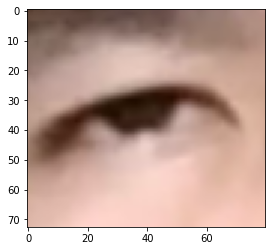

In [13]:
import matplotlib.pyplot as plt 
import cv2 

plt.imshow(cv2.cvtColor(left_eyes[100], cv2.COLOR_RGB2BGR))
plt.show()

In [14]:
import os 

def gen_vid(video_path, imgs, fps, width=None, height=None):
    #Combine video
    ext = video_path.split('.')[1]
    if ext == 'mp4':
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    elif ext == 'avi':
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    else:
        video_path = video_path.replace(ext, 'mp4')
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        
    if width is None or height is None:
        height, width = imgs[0].shape[:2]
    else:
        imgs_ = [cv2.resize(img, (width, height)) for img in imgs]
        imgs = imgs_
    
    out = cv2.VideoWriter(video_path, fourcc, fps, (np.int32(width), np.int32(height)))

    for image in imgs:
        out.write(np.uint8(image))
    
    out.release()
    print('The output video is' + video_path)
    return 

def gen_videos(out_dir, plot_vis_list, tag=''):
    print(input_path_video)
    vid_name = os.path.basename(input_path_video)
    out_path = os.path.join(out_dir, tag + '_' + vid_name)
    print('Generating video: {}'.format(out_path))

    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
        
    # Out folder
    if not os.path.exists(os.path.dirname(out_dir)):
        os.makedirs(os.path.dirname(out_dir))
    
    final_list = []
    print(frame_img)
    for i in tqdm(range(frame_img)):
        final_vis = np.concatenate([align_imgs[i], plot_vis_list[i]], axis=1)
        final_list.append(final_vis)
    
    gen_vid(out_path, final_list, fps)
    
    return



In [15]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns

# Draw line plot
def draw2D(X, Y, order, xname, yname, params, xlim=None, ylim=None, rcparams=None, legend_loc=0):

    title = params['title']
    colors = params['colors']
    markers = params['markers']
    linewidth = params['linewidth']
    markersize = params['markersize']
    figsize = params['figsize']

    if rcparams is None:
        rcparams = {
            'figure.autolayout': True,
            'legend.fontsize': 15,
            'axes.labelsize': 25,
            'axes.titlesize': 25,
            'xtick.labelsize': 25,
            'ytick.labelsize': 25,
            }
        matplotlib.rcParams.update(rcparams)

    X = np.array(X)
    Y = np.array(Y)

    fig = plt.figure(facecolor='white',figsize=figsize)
    plt.title(title)
    plt.ylabel(yname)
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    plt.xlabel(xname)
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])

    for i, type_name in enumerate(order):
        plt.plot(X[i], Y[i], colors[i], label=type_name, linewidth=linewidth, markersize=markersize, marker=markers[i])

    plt.grid()
    plt.legend(loc=legend_loc)
    fig.canvas.draw()
    # grab the pixel buffer and dump it into a numpy array
    im = np.array(fig.canvas.renderer._renderer)[:, :, :-1]
    # plt.show()
    plt.close()
    return im[:, :, (2, 1, 0)]

In [16]:
out_dir = 'cnn_test/'
#Build network 
net = BlinkCNN(is_train=False)
net.build()

sess = tf.compat.v1.Session()
#Init solver
solver = Solver(sess=sess, net=net)
solver.init()

total_eye1_prob = []
total_eye2_prob = []
plot_vis_list = []

if frame_img != len(imgs):
    frame_img = len(imgs)

for i in range(frame_img):
    print('Frame: ' + str(i))
    eye1, eye2 = left_eyes[i], right_eyes[i]
    if eye1 is not None:
        eye1_prob, = solver.test([eye1])
    else:
        eye1_prob = 0.5

    if eye2 is not None:
        eye2_prob, = solver.test([eye2])
    else:
        eye2_prob = 0.5
    
    total_eye1_prob.append(eye1_prob[0, 1])
    total_eye2_prob.append(eye2_prob[0, 1])

    max_X = frame_img / fps
    params = {}
    params['title'] = 'Eye-state-probability'
    params['colors'] = ['b-']
    params['markers'] = [None]
    params['linewidth'] = 3
    params['markersize'] = None
    params['figsize'] = None

    x_axis = np.arange(frame_img) / fps
    # Vis plots
    prob_plot_1 = draw2D([x_axis[:i + 1]],
                        [total_eye1_prob],
                        order=[''],
                        xname='time',
                        yname='eye state',
                        params=params,
                        xlim=[0, max_X],
                        ylim=[-1, 2])
    prob_plot_2 = draw2D([x_axis[:i + 1]],
                            [total_eye2_prob],
                            order=[''],
                            xname='time',
                            yname='eye state',
                            params=params,
                            xlim=[0, max_X],
                            ylim=[-1, 2])

    vis = np.concatenate([prob_plot_1, prob_plot_2], axis=1)
    scale = float(300) / vis.shape[0]
    # Resize plot size to same size with video
    vis = cv2.resize(vis, None, None, fx=scale, fy=scale)
    plot_vis_list.append(vis)

sess.close()
tf.compat.v1.reset_default_graph()
gen_videos(out_dir, plot_vis_list)


No handles with labels found to put in legend.


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 444
Frame: 445


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 446
Frame: 447


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 448
Frame: 449


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 450
Frame: 451


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 452
Frame: 453


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 454
Frame: 455


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 456
Frame: 457


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 458
Frame: 459


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 460
Frame: 461


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 462
Frame: 463


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 464
Frame: 465


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 466
Frame: 467


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 468
Frame: 469


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 470
Frame: 471


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 472
Frame: 473


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 474
Frame: 475


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 476
Frame: 477


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 478
Frame: 479


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 480
Frame: 481


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 482
Frame: 483


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 484
Frame: 485


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 486
Frame: 487


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 488
Frame: 489


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 490
Frame: 491


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 492
Frame: 493


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 494
Frame: 495


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 496
Frame: 497


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 498
Frame: 499


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 500
Frame: 501


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 502


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 503
Frame: 504


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 505
Frame: 506


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 507
Frame: 508


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 509
Frame: 510


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 511
Frame: 512


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 513
Frame: 514


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 515
Frame: 516


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 517
Frame: 518


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 519
Frame: 520


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 521
Frame: 522


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 523
Frame: 524


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 525
Frame: 526


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 527
Frame: 528


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 529
Frame: 530


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 531
Frame: 532


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 533
Frame: 534


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 535
Frame: 536


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 537
Frame: 538


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 539
Frame: 540


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 541
Frame: 542


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 543
Frame: 544


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 545
Frame: 546


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 547
Frame: 548


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 549
Frame: 550


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 551
Frame: 552


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 553
Frame: 554


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 555
Frame: 556


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 557
Frame: 558


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 559
Frame: 560


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 561
Frame: 562


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 563
Frame: 564


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 565
Frame: 566


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 567
Frame: 568


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 569
Frame: 570


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 571
Frame: 572


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 573
Frame: 574


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 575
Frame: 576


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 577
Frame: 578


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 579
Frame: 580


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 581
Frame: 582


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 583
Frame: 584


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 585
Frame: 586


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 587
Frame: 588


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 589
Frame: 590


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 591
Frame: 592


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 593
Frame: 594


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 595
Frame: 596


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 597
Frame: 598


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 599
Frame: 600


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 601
Frame: 602


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 603
Frame: 604


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 605
Frame: 606


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 607
Frame: 608


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 609
Frame: 610


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 611
Frame: 612


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 613
Frame: 614


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 615
Frame: 616


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 617
Frame: 618


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 619
Frame: 620


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 621
Frame: 622


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 623
Frame: 624


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 625
Frame: 626


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 627
Frame: 628


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 629
Frame: 630


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 631
Frame: 632


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 633
Frame: 634


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 635
Frame: 636


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 637
Frame: 638


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 639
Frame: 640


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 641
Frame: 642


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 643
Frame: 644


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 645
Frame: 646


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 647
Frame: 648


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 649
Frame: 650


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 651
Frame: 652


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 653
Frame: 654


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 655
Frame: 656


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 657
Frame: 658


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 659
Frame: 660


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 661
Frame: 662


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 663
Frame: 664


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Frame: 665
Frame: 666


No handles with labels found to put in legend.


video_test.mp4
Generating video: cnn_test/_video_test.mp4
667


100%|██████████| 667/667 [00:00<00:00, 2415.20it/s]


The output video iscnn_test/_video_test.mp4
